In [1]:
# Importing the basic Libraries
import pandas as pd
import numpy as np

In [2]:
# Reading the data and setting the flag to display all columns
df = pd.read_csv("/home/hari/Documents/MLAI/Datasets/mobile_price_classification.csv")
pd.set_option('display.max_columns', None)

In [3]:
# Displaying a small portion of data
df.head()

,battery_power,bluetooth,clock_speed,dual_sim,front_cam,4G,int_memory,m_dep,mobile_wt,n_cores,primary_camera,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


In [4]:
# Chceck whether there are any missing values and check the data types.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   battery_power   2000 non-null   int64  
 1   bluetooth       2000 non-null   int64  
 2   clock_speed     2000 non-null   float64
 3   dual_sim        2000 non-null   int64  
 4   front_cam       2000 non-null   int64  
 5   4G              2000 non-null   int64  
 6   int_memory      2000 non-null   int64  
 7   m_dep           2000 non-null   float64
 8   mobile_wt       2000 non-null   int64  
 9   n_cores         2000 non-null   int64  
 10  primary_camera  2000 non-null   int64  
 11  px_height       2000 non-null   int64  
 12  px_width        2000 non-null   int64  
 13  ram             2000 non-null   int64  
 14  sc_h            2000 non-null   int64  
 15  sc_w            2000 non-null   int64  
 16  talk_time       2000 non-null   int64  
 17  three_g         2000 non-null   i

In [5]:
# Splitting the data into X and y.
X = df.drop('price_range', axis=1)
y = df['price_range']

In [6]:
# Normalizing the data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [7]:
# Importing the necessary libraries.
import optuna
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [8]:
# Define the ANN model
def create_model(num_layers, num_neurons, input_size):
    model = Sequential()
    model.add(Dense(num_neurons, input_dim=input_size, activation="relu"))
    for i in range(num_layers - 1):
        model.add(Dense(num_neurons, activation="relu"))
    model.add(Dense(4, activation="softmax"))
    return model

In [9]:
def objective(trial):
    # Define the hyperparameters to optimize
    num_layers = trial.suggest_int("num_layers", 1, 5)
    num_neurons = trial.suggest_int("num_neurons", 8, 64)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    num_epochs = trial.suggest_int("num_epochs", 10, 100)
    
    # Define the optimizer
    optimizer = Adam(learning_rate=learning_rate)

    # Define the loss function
    loss = "sparse_categorical_crossentropy"

    # Define the data loader
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)
    
    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor="val_loss", patience=5)
    
    # Train the model
    model = create_model(num_layers, num_neurons, X_train.shape[1])
    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
    model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset, callbacks=[early_stopping],verbose=0)

    # Evaluate the model
    _, accuracy = model.evaluate(test_dataset)

    return accuracy

In [10]:
# Define the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Define the study for Optuna
optuna.logging.set_verbosity(optuna.logging.FATAL)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

7/7 [==============================] - 0s 678us/step - loss: 0.1047 - accuracy: 0.9650


7/7 [==============================] - 0s 736us/step - loss: 0.0824 - accuracy: 0.9750


In [15]:
# Print the best hyperparameters and accuracy
print("Best hyperparameters: ", study.best_params)
print("Best accuracy: ", study.best_value)

Best hyperparameters:  {'num_layers': 1, 'num_neurons': 9, 'learning_rate': 0.0030714882961831195, 'batch_size': 64, 'num_epochs': 92}
Best accuracy:  0.9750000238418579


In [16]:
# Define the final model with the best hyperparameters
model = create_model(study.best_params["num_layers"], study.best_params["num_neurons"], X_train.shape[1])
model.compile(optimizer=Adam(learning_rate=study.best_params["learning_rate"]), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=study.best_params["num_epochs"],verbose=0)

In [17]:
# Evaluate the final model
_, accuracy = model.evaluate(X_test, y_test)
print("Final accuracy: ", accuracy)

13/13 [==============================] - 0s 725us/step - loss: 0.0690 - accuracy: 0.9800
Final accuracy:  0.9800000190734863


#### The max accuracy of this model is 98%

We will now try to display feature importance based on connection weights.

In [70]:
# Compute the connection weights
weights = model.get_weights()

In [71]:
# Compute the connection weights
weights = model.get_weights()
input_weights = weights[0]
output_weights = weights[-1]
abs_input_weights = np.abs(input_weights)
abs_output_weights = np.abs(output_weights)
total_weights = np.sum(abs_input_weights) + np.sum(abs_output_weights)
input_weights = abs_input_weights / total_weights
output_weights = abs_output_weights / total_weights
feature_importance = np.sum(input_weights, axis=1)

In [72]:
# Store it into a DataFrame
ranked_features = pd.DataFrame(sorted(zip((df.drop('price_range',axis=1)).columns, feature_importance), key=lambda x: x[1], reverse=True),columns=['Feature','Importance'])

In [73]:
# Display the feature Importance
ranked_features

,Feature,Importance
0,ram,0.325403
1,battery_power,0.073826
2,px_height,0.058991
3,px_width,0.058472
4,mobile_wt,0.038379
5,wifi,0.037280
6,int_memory,0.035688
7,clock_speed,0.034933
8,n_cores,0.034832
9,4G,0.033965


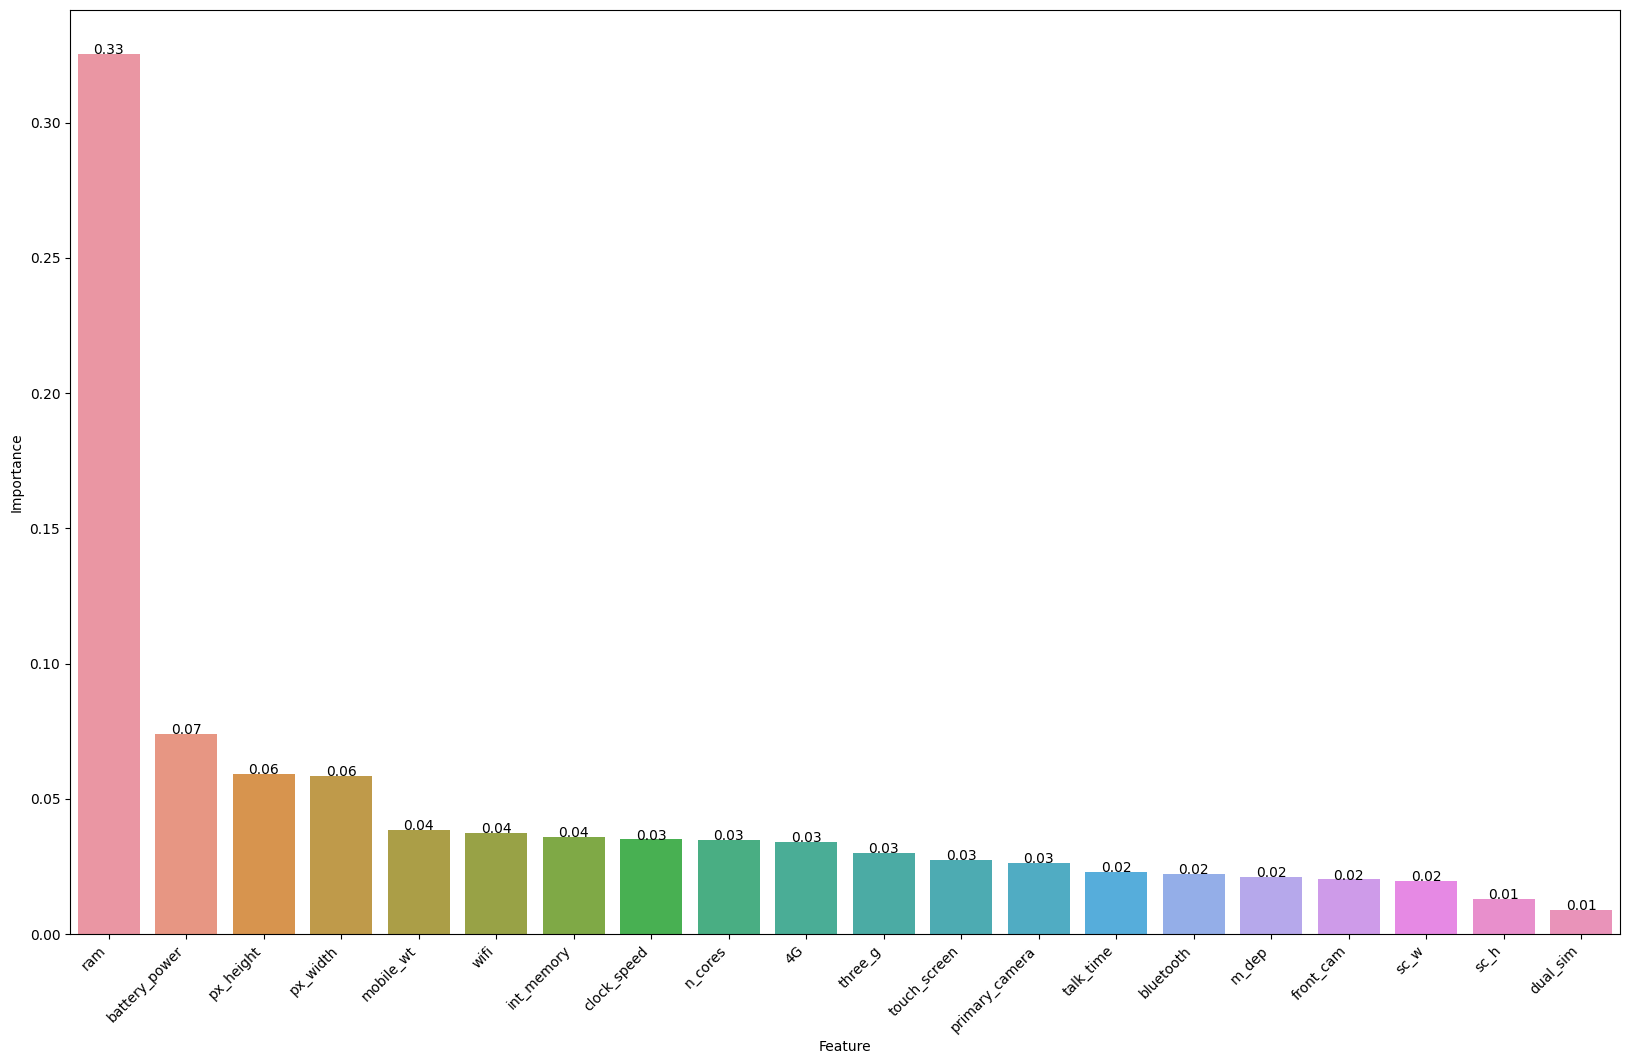

In [74]:
# Display the Feature Importance as a Graph.
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(20, 12))
ax = sns.barplot(x="Feature", y="Importance", data=ranked_features)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
for i, v in enumerate(ranked_features["Importance"]):
    ax.text(i, v, "{:.2f}".format(v), color="black", ha="center")

plt.show()

From the above data we can see that **RAM** has the highest importance when it comes to buying a mobile phone.